In [1]:
# Necessary Imports
import os
import json
from opensearchpy import OpenSearch
import pprint as pp
from sentence_transformers import SentenceTransformer, util
import numpy as np
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel


# 1. Load Dataset and some Analysis

In [30]:
# Load dataset
with open("train.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Count number of moments per video
video_counts = {vid: len(info["timestamps"]) for vid, info in data.items()}

# Sort by most moments and get the top 20
top_videos = sorted(video_counts.items(), key=lambda x: x[1], reverse=True)[:20]

# Print full breakdown for each video
for rank, (video_id, count) in enumerate(top_videos, 1):
    entry = data[video_id]
    timestamps = entry["timestamps"]
    captions = entry["sentences"]
    url = f"https://www.youtube.com/watch?v={video_id[2:]}"

    print(f"\n Rank: {rank}. Video ID: {video_id}")
    print(f" URL: {url}")
    print(f" Number of Moments: {count}")

    for i, ((start,end), caption) in enumerate(zip(timestamps, captions)):
        if i >= 3:
            print(" ...")
            break
        print(f" {i+1:02d}) [{start:.2f} - {end:.2f}] {caption.strip()}")
   


 Rank: 1. Video ID: v_3l7quTy4c2s
 URL: https://www.youtube.com/watch?v=3l7quTy4c2s
 Number of Moments: 27
 01) [0.00 - 7.84] A cheerleader girl stands in the grass.
 02) [4.36 - 7.84] A young man wearing baseball hat greats her with a pie tin and jokes with her.
 03) [7.84 - 15.69] The man pushes a pie tin in the girls face as a joke getting her very messy.
 ...

 Rank: 2. Video ID: v_tuhHQ-lHIs4
 URL: https://www.youtube.com/watch?v=tuhHQ-lHIs4
 Number of Moments: 26
 01) [3.35 - 6.70] A group of kids poses with the arms in the air.
 02) [8.13 - 10.52] Another group of kids poses holding up peace signs.
 03) [11.00 - 13.39] A third group of kids poses with their arms around each other.
 ...

 Rank: 3. Video ID: v_-rKS00dzFxQ
 URL: https://www.youtube.com/watch?v=-rKS00dzFxQ
 Number of Moments: 22
 01) [8.10 - 23.14] A man and a woman stand by a table speaking to the camera.
 02) [24.30 - 39.34] A recipe of mashed potatoes sits on the table.
 03) [40.50 - 53.23] The man peels and cut

# 2. Create OpenSearch Index + Mappings

In [2]:
# Setup OpeanSearch connection
host = 'api.novasearch.org'
port = 443
user = 'user04'
password = 'no.LIMITS2100'
index_name = user

# Create OpenSearch client
client = OpenSearch(
    hosts=[{'host': host, 'port': port}],
    http_compress = True,
    http_auth = (user, password),
    use_ssl = True,
    url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False,
)

In [3]:
# Define index setting and mappings
index_body = {
    "settings": {
        "index": {
            "number_of_shards": 4,
            "number_of_replicas": 0,
            "refresh_interval": "1s",
            "knn": "true"
        }
    },
    "mappings": {
        "dynamic": "strict",
        "properties": {
            "video_id": {"type": "keyword"},
            "video_url": {"type": "keyword"},
            "start": {"type": "float"},
            "end": {"type": "float"},
            "duration": {"type": "float"},
            "caption_bow": {"type": "text", "analyzer": "standard", "similarity": "BM25"},
            "caption_vec": {"type": "knn_vector", "dimension": 384},
            "keyframe_vec":  { "type": "knn_vector", "dimension": 384 },
            "image_vec":  { "type": "knn_vector", "dimension": 512 },
            "image_path": { "type": "keyword" },
            "entities":      { "type": "keyword" },
            "actions":       { "type": "keyword" }
        }
    }
}

# Create index only if not exists
if client.indices.exists(index=index_name):
    print("Index already exists.")
else:
    response = client.indices.create(index=index_name, body=index_body)
    print("Index created.")
    pp.pprint(response)

# For Debug: Display index settings and mappings
print("\nIndex Settings:")
pp.pprint(client.indices.get_settings(index=index_name))

print("\nIndex Mappings:")
pp.pprint(client.indices.get_mapping(index=index_name))

Index already exists.

Index Settings:
{'user04': {'settings': {'index': {'creation_date': '1746725219815',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '4',
                                   'provided_name': 'user04',
                                   'refresh_interval': '1s',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': 'Bgc_ug9rTnGD2wjAFy7AQw',
                                   'version': {'created': '136387927'}}}}}

Index Mappings:
{'user04': {'mappings': {'dynamic': 'strict',
                         'properties': {'actions': {'type': 'keyword'},
                                        'caption_bow': {'analyzer': 'standard',
                                                        'similarity': 'BM25',
                                                        'type': 'text'},
               

In [58]:
#Uncomment to run

#Index Deletion (uncomment to run)
if client.indices.exists(index=index_name):
    # Delete the index
    response = client.indices.delete(
        index = index_name
    )
    print('\nDeleting index:')
    print(response)


Deleting index:
{'acknowledged': True}


# 4. Index Documents (Text + Embeddings)

In [34]:
# Load the BERT model (384-dim)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Our 10 selected video IDs
selected_ids = [
    "v_-rKS00dzFxQ", # How to Cook Mashed Potatoes
    "v_-fjUWhSM6Hc", # London 2012 Olympics
    "v_v7o9uSu9AVI", # 20 Exercises on Parallel Bars
    "v_RJpWgi0EaUE", # Vin Diesel Breakdancing Throwback
    "v_G7kqlq8WhRo", # Twickenham Festival 2015 Tug of War
    "v_jTMdMnbW9OI", # Washing my Face
    "v_9wtMJoqGTg0", # Girl in Balance Beam (gymnastics)
    "v_Ffi7vDa3C2I", # Epic Rollerblading Montage 80s
    "v_JRr3BruqS2Y", # 'What U think about Rollerblading?'
    "v_Mkljhl3D9-Q", # Preparing Angel Hair Pasta
]

# Load train.json
with open("train.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Index each moment
doc_id = 0
for video_id in selected_ids:
    entry = data.get(video_id)
    if not entry:
        continue

    url = f"https://www.youtube.com/watch?v={video_id[2:]}"
    duration = float(entry["duration"])
    timestamps = entry["timestamps"]
    captions = entry["sentences"]

    for (start, end), caption in zip(timestamps, captions):
        doc_id += 1

        # Compute the embedding
        embedding = model.encode(caption.strip(), normalize_embeddings=True).tolist()

        # Create the document
        doc = {
            "video_id": video_id,
            "video_url": url,
            "start": float(start),
            "end": float(end),
            "duration": duration,
            "caption_bow": caption.strip(),
            "caption_vec": embedding
        }

        # Index in OpenSearch
        response = client.index(index=index_name, id=doc_id, body=doc)
        print(f"Indexed document ID {doc_id} for video {video_id}: {response['result']}")

Indexed document ID 1 for video v_-rKS00dzFxQ: created
Indexed document ID 2 for video v_-rKS00dzFxQ: created
Indexed document ID 3 for video v_-rKS00dzFxQ: created
Indexed document ID 4 for video v_-rKS00dzFxQ: created
Indexed document ID 5 for video v_-rKS00dzFxQ: created
Indexed document ID 6 for video v_-rKS00dzFxQ: created
Indexed document ID 7 for video v_-rKS00dzFxQ: created
Indexed document ID 8 for video v_-rKS00dzFxQ: created
Indexed document ID 9 for video v_-rKS00dzFxQ: created
Indexed document ID 10 for video v_-rKS00dzFxQ: created
Indexed document ID 11 for video v_-rKS00dzFxQ: created
Indexed document ID 12 for video v_-rKS00dzFxQ: created
Indexed document ID 13 for video v_-rKS00dzFxQ: created
Indexed document ID 14 for video v_-rKS00dzFxQ: created
Indexed document ID 15 for video v_-rKS00dzFxQ: created
Indexed document ID 16 for video v_-rKS00dzFxQ: created
Indexed document ID 17 for video v_-rKS00dzFxQ: created
Indexed document ID 18 for video v_-rKS00dzFxQ: created
I

## Text-based search

In [35]:
# BM25 Keyword Search
# This query uses classic keyword-based search over the caption_bow field.
# It ranks results based on word overlap between the query and the caption.
# BM25 does not understand synonyms or semantic meaning.

# Based on the Lab02a_OpeanSearch text-based search
qtxt = "woman talking"

query_bm25 = {
    "size": 5,
    "_source": ["video_id", "video_url", "start", "end", "caption_bow"],
    "query": {
        "match": {
            "caption_bow": qtxt
        }
    }
}

response = client.search(index=index_name, body=query_bm25)

print("\nBM25 Keyword Search Results:")
for hit in response["hits"]["hits"]:
    doc = hit["_source"]
    print(f"- {doc['video_id']} [{doc['start']:.2f}-{doc['end']:.2f}]: {doc['caption_bow']}")


res = client.count(index=index_name)
print(f"Indexed docs: {res['count']}")


BM25 Keyword Search Results:
- v_JRr3BruqS2Y [106.84-119.08]: A woman in a brown hat is talking.
- v_JRr3BruqS2Y [152.47-163.60]: A woman in a pink shirt is talking.
- v_JRr3BruqS2Y [214.80-222.59]: An older woman is talking to the camera.
- v_JRr3BruqS2Y [72.34-77.91]: It goes back to the man in the black shirt talking.
- v_JRr3BruqS2Y [63.44-70.11]: It goes back to the man in a black hat talking.
Indexed docs: 182


In [36]:
# Semantic Search (KNN Vector Query)
# Encodes the query text as a 384-dimensional embedding using Sentence-BERT.
# Uses k-Nearest Neighbors search to find semantically similar captions.
# Returns top 5 moments that are most conceptually similar, even if they don't share keywords.

# Semantic Search (KNN Vector Query)
query_text = "man dancing"
embedding = model.encode(query_text, normalize_embeddings=True).tolist()

query_knn = {
    "size": 5,
    "_source": ["video_id", "video_url", "start", "end", "caption_bow"],
    "query": {
        "knn": {
            "caption_vec": {
                "vector": embedding,
                "k": 5
            }
        }
    }
}

response = client.search(index=index_name, body=query_knn)

print(f"\n Semantic Search Results for '{query_text}':")
for hit in response["hits"]["hits"]:
    doc = hit["_source"]
    print(f"- {doc['video_id']} [{doc['start']:.2f}-{doc['end']:.2f}]: {doc['caption_bow']}")


 Semantic Search Results for 'man dancing':
- v_RJpWgi0EaUE [172.22-177.47]: The man in a black suit dances and then sits.
- v_RJpWgi0EaUE [16.80-19.95]: An image of a man is incorporated into the screen with the dancers.
- v_RJpWgi0EaUE [40.95-45.16]: The man and woman gesture the dancers hand movements.
- v_RJpWgi0EaUE [8.40-27.30]: Two boys dance in the same fashion.
- v_RJpWgi0EaUE [128.12-131.27]: The man claps his hands together.


### Search with filters

In [37]:
qtxt = "woman"

filter = {"range": {
            "duration": {
                "lt": 230   # lt = lower than ; gt = greater than ; gte = ... or equal
            }
          }
        }

query_bm25_with_filter = {
    "size": 5,
    "_source": ["video_id", "video_url", "start", "end", "duration", "caption_bow"],
    "query": {
        "bool": {
            "must": [
                {"match": {"caption_bow": qtxt}}
            ],
            "filter": [
                filter
            ]
        }
    }
}

response = client.search(index=index_name, body=query_bm25_with_filter)

print(f"\nBM25 Keyword Search Results:(with Duration Filter Search Results for '{qtxt}' (duration < 180s):")
for hit in response["hits"]["hits"]:
    doc = hit["_source"]
    print(f"- {doc['video_id']} [{doc['start']:.2f}-{doc['end']:.2f}] ({doc['duration']:.1f}s): {doc['caption_bow']}")


BM25 Keyword Search Results:(with Duration Filter Search Results for 'woman' (duration < 180s):
- v_JRr3BruqS2Y [214.80-222.59] (222.6s): An older woman is talking to the camera.
- v_RJpWgi0EaUE [40.95-45.16] (210.0s): The man and woman gesture the dancers hand movements.
- v_JRr3BruqS2Y [106.84-119.08] (222.6s): A woman in a brown hat is talking.
- v_JRr3BruqS2Y [152.47-163.60] (222.6s): A woman in a pink shirt is talking.
- v_JRr3BruqS2Y [25.60-36.73] (222.6s): A woman in a grey sweater talks to the camera on the sidewalk.


 ### Different Mappings  

 #### Testing the different maps

In [38]:
# Define index setting and mappings
index_body_optimized = {
    "settings": {
        "index": {
            "number_of_shards": 4,
            "number_of_replicas": 0,
            "refresh_interval": "1s",
            "knn": "true"
        }
    },
    "mappings": {
        "dynamic": "strict",
        "properties": {
            "video_id": {"type": "keyword"},
            "video_url": {"type": "keyword"},
            "start": {"type": "float"},
            "end": {"type": "float"},
            "duration": {"type": "float"},
            "caption_bow": {"type": "text", "analyzer": "standard", "similarity": "BM25"},
            "caption_vec": {"type": "knn_vector", "dimension": 384},
            "keyframe_vec":  { "type": "knn_vector", "dimension": 384 }, ##added feature
            "entities":      { "type": "keyword" },           ##added feature
            "actions":       { "type": "keyword" }           ##added feature
        }
    }
}

In [39]:
# Recreate the index with optimized mapping
if client.indices.exists(index=index_name):
    client.indices.delete(index=index_name)

response = client.indices.create(index=index_name, body=index_body_optimized)
print("Index created with optimized mapping.")
pp.pprint(response)

# Display the updated mapping
print("\nUpdated Index Mapping:")
pp.pprint(client.indices.get_mapping(index=index_name))

Index created with optimized mapping.
{'acknowledged': True, 'index': 'user04', 'shards_acknowledged': True}

Updated Index Mapping:
{'user04': {'mappings': {'dynamic': 'strict',
                         'properties': {'actions': {'type': 'keyword'},
                                        'caption_bow': {'analyzer': 'standard',
                                                        'similarity': 'BM25',
                                                        'type': 'text'},
                                        'caption_vec': {'dimension': 384,
                                                        'type': 'knn_vector'},
                                        'duration': {'type': 'float'},
                                        'end': {'type': 'float'},
                                        'entities': {'type': 'keyword'},
                                        'keyframe_vec': {'dimension': 384,
                                                         'type': 'knn_vector'},


 #### Re-indexing all the docs


In [40]:
# Load the BERT model (384-dim)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Our 10 selected video IDs
selected_ids = [
    "v_-rKS00dzFxQ", "v_-fjUWhSM6Hc", "v_v7o9uSu9AVI", "v_RJpWgi0EaUE",
    "v_G7kqlq8WhRo", "v_jTMdMnbW9OI", "v_9wtMJoqGTg0", "v_Ffi7vDa3C2I",
    "v_JRr3BruqS2Y", "v_Mkljhl3D9-Q",
]

# Load train.json
with open("train.json", "r", encoding="utf-8") as f:
    data = json.load(f)

doc_id = 0
for video_id in selected_ids:
    entry = data.get(video_id)
    if not entry:
        continue

    url = f"https://www.youtube.com/watch?v={video_id[2:]}"
    duration = float(entry["duration"])
    timestamps = entry["timestamps"]
    captions = entry["sentences"]

    for (start, end), caption in zip(timestamps, captions):
        doc_id += 1

        embedding = model.encode(caption.strip(), normalize_embeddings=True).tolist()

        # Example entity/action values
        entities = ["woman", "gymnast"] if "girl" in caption.lower() or "woman" in caption.lower() else ["man"]
        actions = ["jump", "flip"] if "flip" in caption.lower() else ["stand"]

        doc = {
            "video_id": video_id,
            "video_url": url,
            "start": float(start),
            "end": float(end),
            "duration": duration,
            "caption_bow": caption.strip(),
            "caption_vec": embedding,
            "keyframe_vec": embedding,  # just reuse caption_vec for now
            "entities": entities,
            "actions": actions
        }

        response = client.index(index=index_name, id=doc_id, body=doc)
        print(f"Indexed document ID {doc_id} for video {video_id}: {response['result']}")


Indexed document ID 1 for video v_-rKS00dzFxQ: created
Indexed document ID 2 for video v_-rKS00dzFxQ: created
Indexed document ID 3 for video v_-rKS00dzFxQ: created
Indexed document ID 4 for video v_-rKS00dzFxQ: created
Indexed document ID 5 for video v_-rKS00dzFxQ: created
Indexed document ID 6 for video v_-rKS00dzFxQ: created
Indexed document ID 7 for video v_-rKS00dzFxQ: created
Indexed document ID 8 for video v_-rKS00dzFxQ: created
Indexed document ID 9 for video v_-rKS00dzFxQ: created
Indexed document ID 10 for video v_-rKS00dzFxQ: created
Indexed document ID 11 for video v_-rKS00dzFxQ: created
Indexed document ID 12 for video v_-rKS00dzFxQ: created
Indexed document ID 13 for video v_-rKS00dzFxQ: created
Indexed document ID 14 for video v_-rKS00dzFxQ: created
Indexed document ID 15 for video v_-rKS00dzFxQ: created
Indexed document ID 16 for video v_-rKS00dzFxQ: created
Indexed document ID 17 for video v_-rKS00dzFxQ: created
Indexed document ID 18 for video v_-rKS00dzFxQ: created
I

In [41]:
# Example query embedding for KNN search (this can be any query text like "woman jumping")
query_keyframe_embedding = model.encode("woman jumping", normalize_embeddings=True).tolist()

# Combined query with KNN search for `keyframe_vec`, and filters for `entities` and `actions`
query_combined = {
    "size": 5,
    "_source": ["video_id", "video_url", "start", "end", "caption_bow", "keyframe_vec", "entities", "actions"],
    "query": {
        "bool": {
            "must": [
                # KNN search on the keyframe_vec field
                {
                    "knn": {
                        "keyframe_vec": {
                            "vector": query_keyframe_embedding,  # The query embedding for keyframe
                            "k": 5  # Get the top 5 closest matches based on the keyframe vector
                        }
                    }
                },
                # Filter for entities that match "woman"
                {
                    "term": {
                        "entities": "woman"  # Search for the entity "woman"
                    }
                },
                # Filter for actions that match "jump"
                {
                    "term": {
                        "actions": "jump"  # Search for the action "jump"
                    }
                }
            ]
        }
    }
}

# Perform the query
response_combined = client.search(index=index_name, body=query_combined)

# Print results
print("\nCombined Search based on Keyframe Vector, Entities, and Actions:")
for hit in response_combined["hits"]["hits"]:
    doc = hit["_source"]
    video_id = doc["video_id"]
    video_url = doc["video_url"]
    start = doc["start"]
    end = doc["end"]
    caption_bow = doc["caption_bow"]
    keyframe_vec = doc.get("keyframe_vec", "No keyframe vector")  # Handle missing keyframe vector
    entities = doc.get("entities", [])
    actions = doc.get("actions", [])

    print(f"- {video_id} [{start:.2f}-{end:.2f}]: {caption_bow}")
    print(f"  Video URL: {video_url}")
    print(f"  Entities: {entities}")
    print(f"  Actions: {actions}")



Combined Search based on Keyframe Vector, Entities, and Actions:
- v_9wtMJoqGTg0 [40.62-50.89]: The girl turns, jumps in place, and back flips.
  Video URL: https://www.youtube.com/watch?v=9wtMJoqGTg0
  Entities: ['woman', 'gymnast']
  Actions: ['jump', 'flip']
- v_9wtMJoqGTg0 [29.02-33.03]: The girl back flips three times.
  Video URL: https://www.youtube.com/watch?v=9wtMJoqGTg0
  Entities: ['woman', 'gymnast']
  Actions: ['jump', 'flip']
- v_9wtMJoqGTg0 [34.37-38.84]: The girl takes two steps and front flips.
  Video URL: https://www.youtube.com/watch?v=9wtMJoqGTg0
  Entities: ['woman', 'gymnast']
  Actions: ['jump', 'flip']
- v_9wtMJoqGTg0 [64.28-71.87]: The girls steps forward and front flips and lands at the edge.
  Video URL: https://www.youtube.com/watch?v=9wtMJoqGTg0
  Entities: ['woman', 'gymnast']
  Actions: ['jump', 'flip']
- v_9wtMJoqGTg0 [83.03-89.28]: The girl back flips three times off the bar and lands on a blue mat.
  Video URL: https://www.youtube.com/watch?v=9wtMJoq

## Contextual Embeddings & Self-Attention

In [42]:
# Load necessary pre trained model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

dual_encoder_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
cross_encoder_model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
cross_tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")

### Visualize Contextual Word Embeddings (Layer-wise)

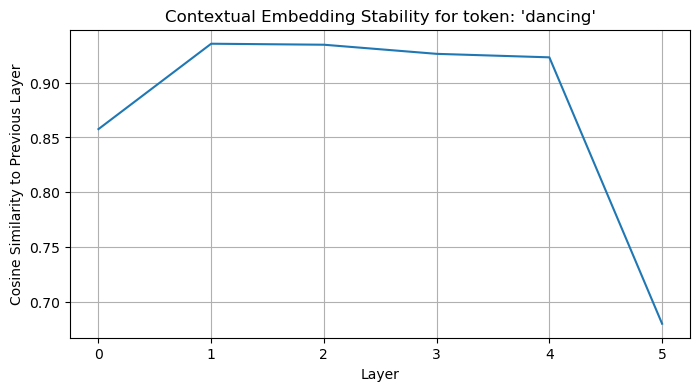

In [43]:
# Input sentence
sentence = "A man is dancing on stage"
token_to_track = "dancing"   # use also: man / stage
# token_to_track = sentence.split(" ")[3]

inputs = tokenizer(sentence, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# Hidden states: list of tensors (1 per layer)
hidden_states = outputs.hidden_states  # List: [embedding_layer, layer1, ..., layerN]
token_ids = inputs["input_ids"][0]
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# Token to track
token_index = tokens.index(token_to_track)

# Extract vector per layer
token_vecs = [layer[0, token_index].numpy() for layer in hidden_states]

# Plot similarity across layers
similarities = [torch.nn.functional.cosine_similarity(torch.tensor(token_vecs[i]), torch.tensor(token_vecs[i+1]), dim=0).item() for i in range(len(token_vecs)-1)]

plt.figure(figsize=(8, 4))
sns.lineplot(x=list(range(len(similarities))), y=similarities)
plt.title(f"Contextual Embedding Stability for token: '{token_to_track}'")
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity to Previous Layer")
plt.grid(True)
plt.show()


Initially, the embedding of the token remains almost the same during all first 5 layers. In the final layer it refines the information by changing a lot the embedding of the token.
This means that the model is refining very slowly, not changing embeddings until the last layer

#### Compare similarity for the same token in 2 different sentences

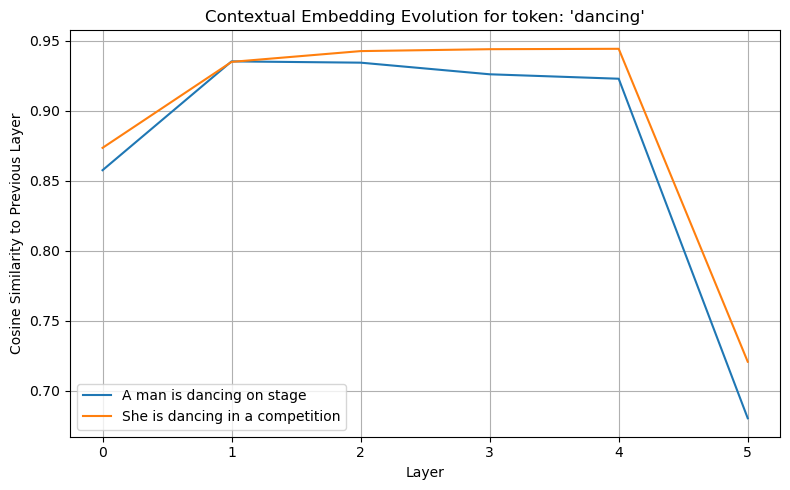

In [44]:
# Load previous model to eval
model.eval()

# Input sentences to compare
sentences = [
    "A man is dancing on stage",
    "She is dancing in a competition"
]
token_to_track = "dancing"

# Store token vectors per layer for each sentence
token_vecs_per_sentence = []

for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    try:
        token_index = tokens.index(token_to_track)
    except ValueError:
        raise ValueError(f"Token '{token_to_track}' not found in: {tokens}")
    
    token_vecs = [layer[0, token_index].numpy() for layer in hidden_states]
    token_vecs_per_sentence.append(token_vecs)

# Compare cosine similarities across layers for both sentences
similarities = []
for vecs in token_vecs_per_sentence:
    sims = [torch.nn.functional.cosine_similarity(torch.tensor(vecs[i]), torch.tensor(vecs[i+1]), dim=0).item()
            for i in range(len(vecs)-1)]
    similarities.append(sims)

plt.figure(figsize=(8, 5))
layers = list(range(len(similarities[0])))
for i, sims in enumerate(similarities):
    sns.lineplot(x=layers, y=sims, label=sentences[i])

plt.title(f"Contextual Embedding Evolution for token: '{token_to_track}'")
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity to Previous Layer")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Different behavior for the same token when in different sentences.

### Analyze positional embeddings (repetition behavior)

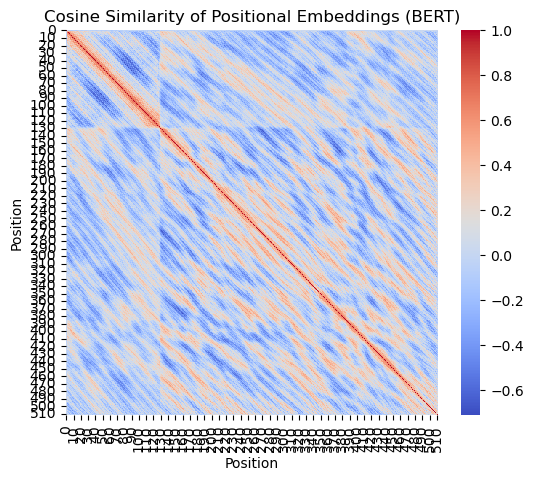

In [45]:
pos_embed = bert_model.embeddings.position_embeddings.weight.detach().numpy()

# Plot similarity between positional vectors
sim_matrix = torch.nn.functional.cosine_similarity(
    torch.tensor(pos_embed[:, None, :]), torch.tensor(pos_embed[None, :, :]), dim=-1
).numpy()

plt.figure(figsize=(6, 5))
sns.heatmap(sim_matrix, cmap="coolwarm", xticklabels=10, yticklabels=10)
plt.title("Cosine Similarity of Positional Embeddings (BERT)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

We can verify that close positions have very similar embeddings (as expected), so BERT captures position information gradually. There also seem to be some repeating patterns, which might mean BERT reuses position signals in a structured way

### Examine self-attention in dual vs. cross encoders

In [46]:
query = "The man cuts up some garlic"
passage = "the man throws the garlic along with two leaves"

# Dual encoder: separate encoding
query_vec = dual_encoder_model.encode(query, convert_to_tensor=True)
passage_vec = dual_encoder_model.encode(passage, convert_to_tensor=True)
similarity_dual = util.cos_sim(query_vec, passage_vec).item()

inputs = cross_tokenizer(query, passage, return_tensors="pt", truncation=True)
with torch.no_grad():
    logits = cross_encoder_model(**inputs).logits
    similarity_cross = logits[0][0].item()

print(f"Dual Encoder Similarity: {similarity_dual:.4f}") # 1.0 maximum similarity ; -1.0 opposite similarity ; 0.0 no similarity
print(f"Cross Encoder Score: {similarity_cross:.4f}") # different metric from dual encoder

Dual Encoder Similarity: 0.6585
Cross Encoder Score: 5.3529


In [47]:
# Turn similarity score from cross encoder to probability (to campare directly with dual encoder metric)
probability = torch.sigmoid(torch.tensor(similarity_cross)).item()
print(f"Cross Encoder Similarity: {probability:.4f}")

Cross Encoder Similarity: 0.9953


The cross encoder has a higher score of similarity between the 2 sentences than the dual encoder, which means that the cross encoder is more certain that the sentences are correlated. The sentences were taken from the same video, from 2 consecutive moments and with similar themes, so they should be strongly correlated, in theory.

### Visualize Token Attention Across Layers

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


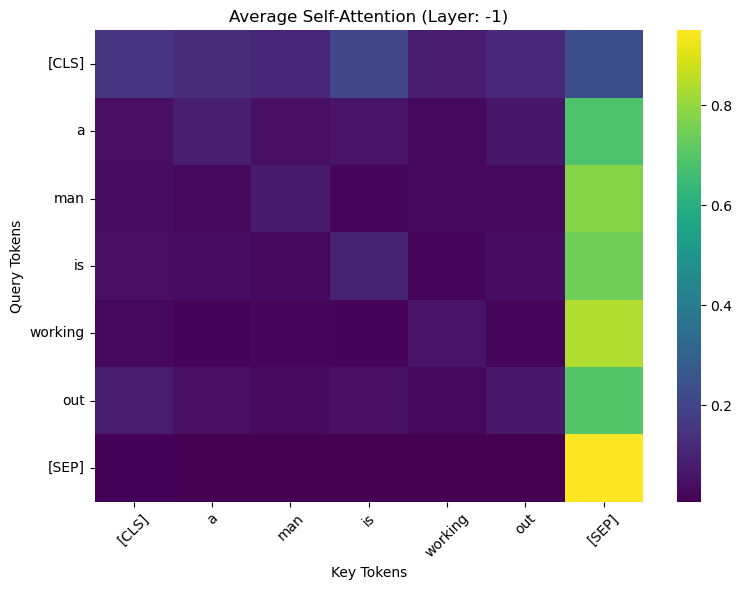

In [48]:
# Load model with attentions enabled
bert_model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
bert_model.eval()

# Input sentence
sentence = "A man is working out"
inputs = bert_tokenizer(sentence, return_tensors="pt")

# Run bert_model
with torch.no_grad():
    outputs = bert_model(**inputs)

attentions = outputs.attentions  # tuple of length num_layers

attentions_tensor = torch.stack(attentions)  # shape: layers x batch x heads x tokens x tokens
avg_attention = attentions_tensor.mean(dim=2).squeeze(1)  # average over heads - remove batch dim

# Layer to visualize
layer_to_plot = -1   # -1 = last layer
tokens = bert_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(avg_attention[layer_to_plot].numpy(), xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Average Self-Attention (Layer: {layer_to_plot})")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Normal for BERT model to have more attention to element '[SEP]', because the closing element works like an anchor that helps the model to close and join the sentence information.